In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)
import seaborn as sns

In [2]:
data= pd.read_csv('Datos_Prueba_DataScientist.csv', sep=',')
data.head()

,OrderId,RequestTime,DeliveryOption
0,PED_1,2018-01-01 08:03:12,Mismo dia entre 6:30 pm y 8:30 pm
1,PED_2,2018-01-01 08:28:55,Mismo dia entre 6:30 pm y 8:30 pm
2,PED_3,2018-01-01 08:39:08,Mismo dia entre 6:30 pm y 8:30 pm
3,PED_4,2018-01-01 09:25:07,Siguiente dia entre 12:30 pm y 2:30 pm
4,PED_5,2018-01-01 09:36:25,Siguiente dia entre 12:30 pm y 2:30 pm


In [3]:
data.shape

(153275, 3)

In [4]:
data.isnull().sum()

OrderId           0
RequestTime       0
DeliveryOption    0
dtype: int64

In [5]:
data['OrderId'].unique().shape

(153275,)

In [6]:
data['DeliveryOption'].unique()

array(['Mismo dia entre 6:30 pm y 8:30 pm',
       'Siguiente dia entre 12:30 pm y 2:30 pm',
       'Siguiente dia entre las 6:30 pm y 8:30 pm'], dtype=object)

In [7]:
data.dtypes

OrderId           object
RequestTime       object
DeliveryOption    object
dtype: object

In [8]:
data['RequestTime']=pd.to_datetime(data.RequestTime, format='%Y-%m-%d %H:%M:%S')

In [9]:
data['DeliveryOption']=data.DeliveryOption.astype('category')

In [10]:
data.dtypes

OrderId                   object
RequestTime       datetime64[ns]
DeliveryOption          category
dtype: object

In [11]:
df=data.copy()

In [12]:
df['date']=df.RequestTime.dt.date

In [13]:
dfByRequestTime=df.groupby(['RequestTime', 'DeliveryOption'])[['OrderId']].count().unstack()


In [14]:
dfByHour=dfByRequestTime.resample('H').sum()

In [15]:
dfByDay=dfByRequestTime.resample('d').sum()

<AxesSubplot:xlabel='RequestTime'>

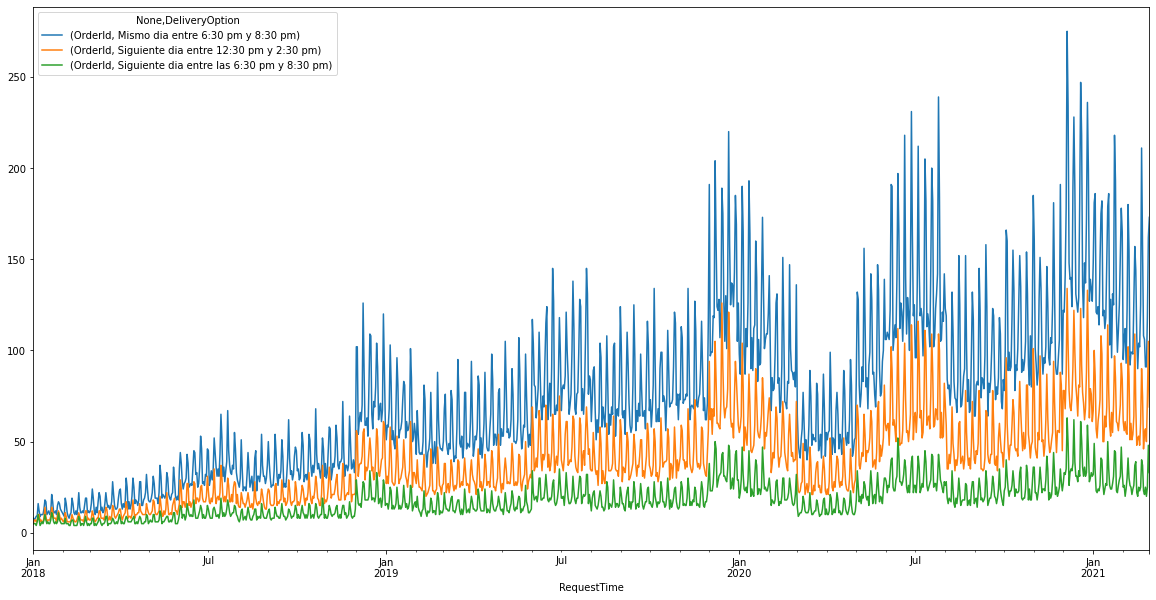

In [16]:
dfByDay.plot()

<AxesSubplot:xlabel='RequestTime'>

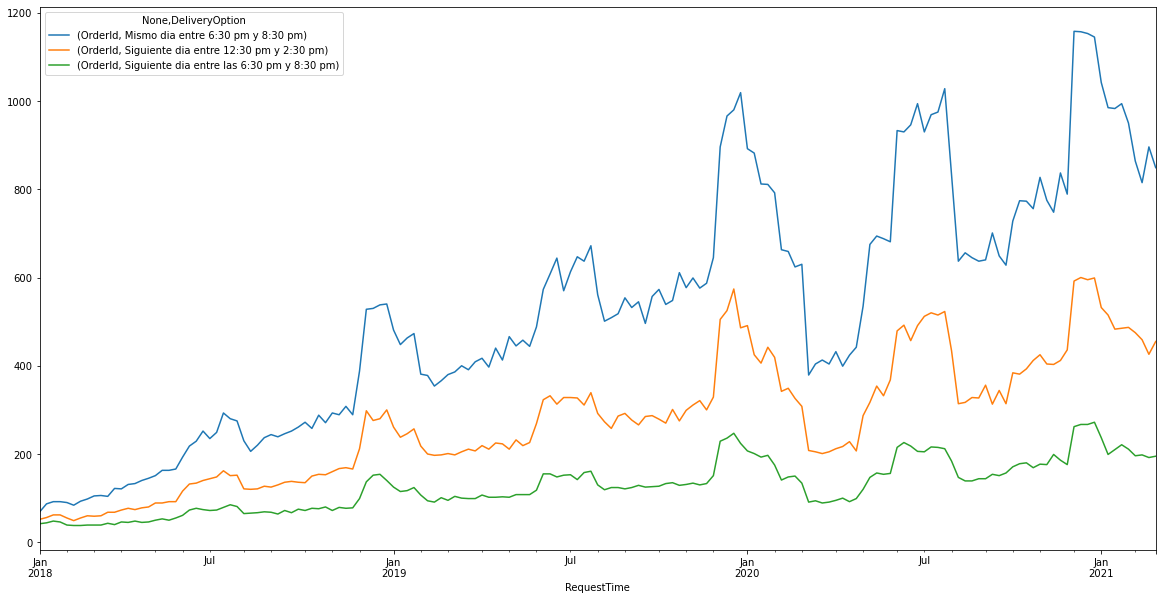

In [17]:
dfByRequestTime.resample('w').sum().plot()

<AxesSubplot:xlabel='RequestTime'>

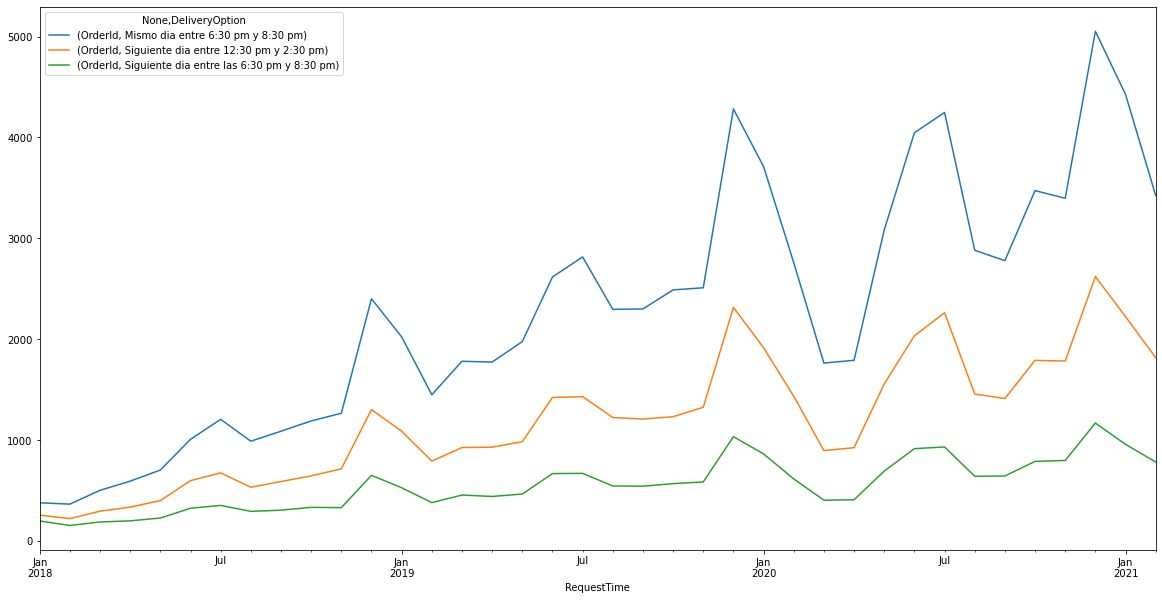

In [18]:
dfByRequestTime.resample('M').sum().plot()

<AxesSubplot:xlabel='RequestTime'>

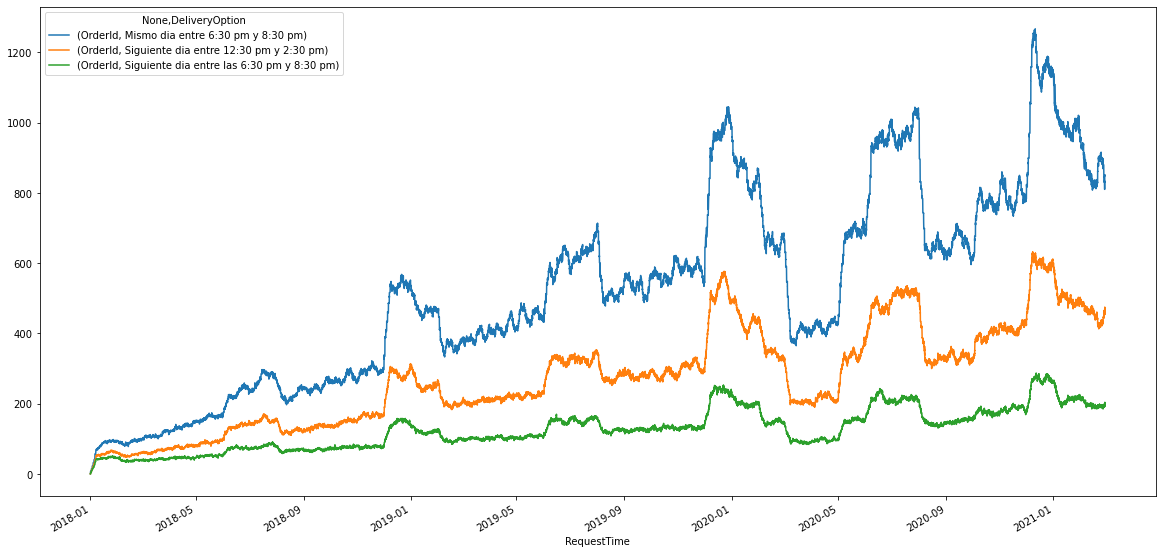

In [19]:
dfByRequestTime.rolling('7d').sum().plot()

1. La opción 1 (entrega en el mismo día) debe ser alistada en el turno de tarde
2. La opción 2 (entrega al día siguiente a 12:30), no se especifica pero al empacarse el producto el mismo día debe tenerse en cuenta en el turno de la mañana 
3. La opción 3 (entrega al día siguiente 6:30) debe atenderse en el turno de la mañana.

El turno de la tarde compuesto por las ordenes de entrega inmediata (opción 1) y el de la mañana con las ordenes de dia posterior (opción 2 y 3) con un retraso de un día

In [20]:
dfByDay.columns

MultiIndex([('OrderId',         'Mismo dia entre 6:30 pm y 8:30 pm'),
            ('OrderId',    'Siguiente dia entre 12:30 pm y 2:30 pm'),
            ('OrderId', 'Siguiente dia entre las 6:30 pm y 8:30 pm')],
           names=[None, 'DeliveryOption'])

In [21]:
dfByDay.columns=['Option_1', 'Option_2', 'Option_3']

In [22]:
df=dfByDay.copy()
df['year']=dfByDay.index.year
df['month']=dfByDay.index.month
df['weekday']=dfByDay.index.weekday

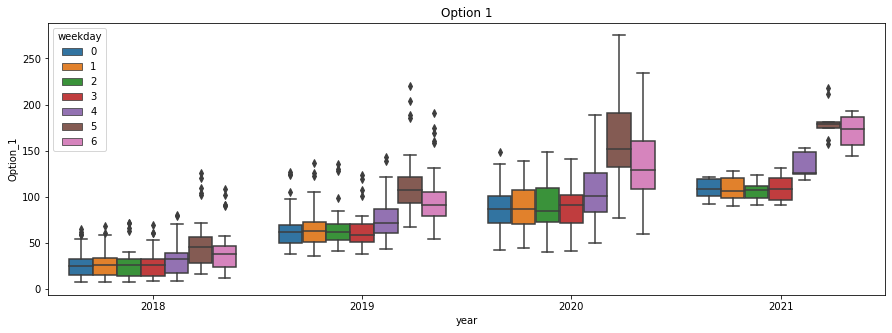

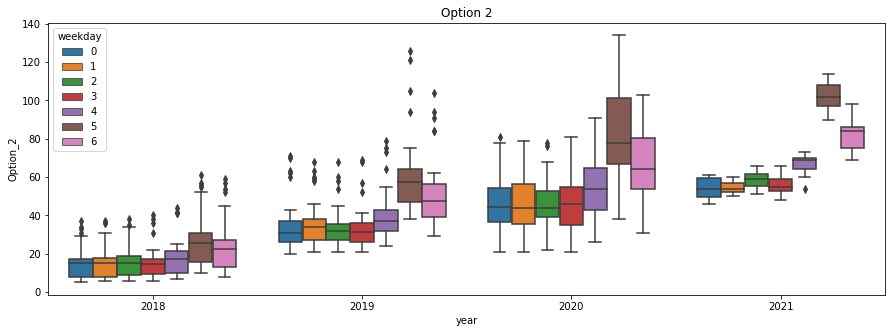

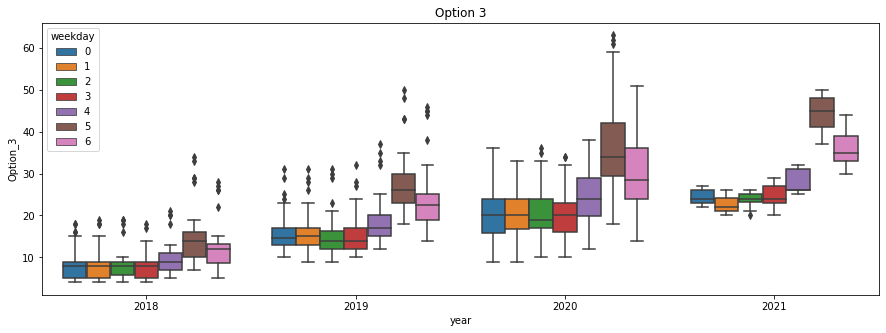

In [23]:
plt.rcParams["figure.figsize"] = (15, 5)
sns.boxplot(x='year', y='Option_1', hue='weekday', data=df)
plt.title('Option 1')
plt.show()
sns.boxplot(x='year', y='Option_2', hue='weekday', data=df)
plt.title('Option 2')
plt.show()
sns.boxplot(x='year', y='Option_3', hue='weekday', data=df)
plt.title('Option 3')
plt.show()

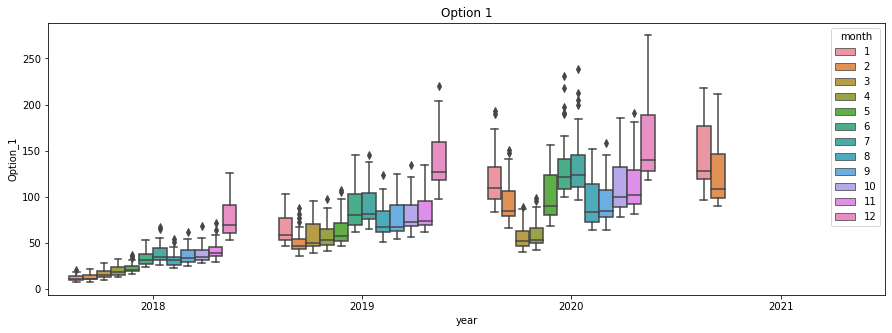

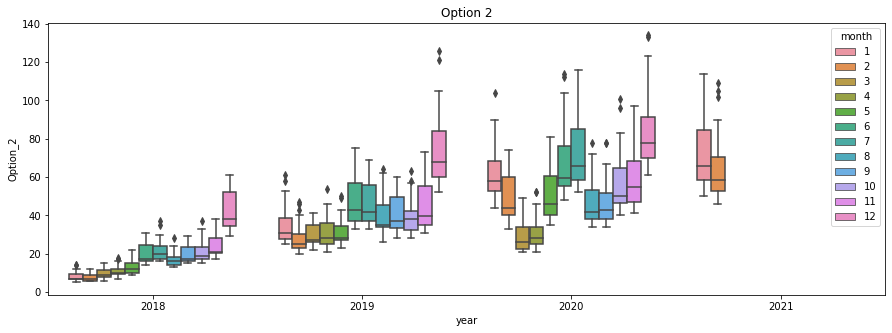

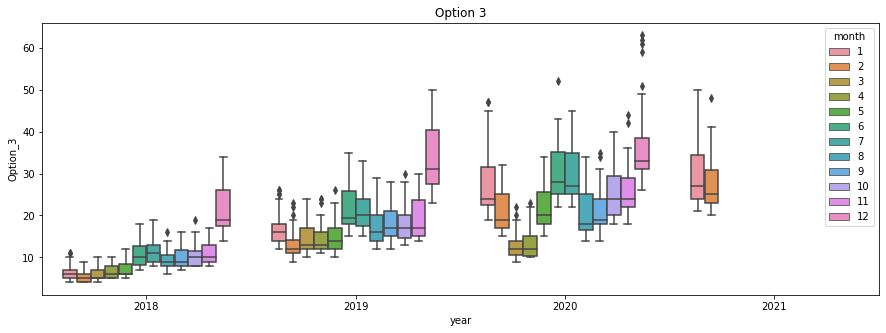

In [24]:
plt.rcParams["figure.figsize"] = (15, 5)
sns.boxplot(x='year', y='Option_1', hue='month', data=df)
plt.title('Option 1')
plt.show()
sns.boxplot(x='year', y='Option_2', hue='month', data=df)
plt.title('Option 2')
plt.show()
sns.boxplot(x='year', y='Option_3', hue='month', data=df)
plt.title('Option 3')
plt.show()

Se observa que el mes de diciembre presenta una considerable diferencia en la media con respecto al resto de meses, seguido de junio y julio. Es posible que se deba a la temporada de vacaciones.

<AxesSubplot:xlabel='RequestTime'>

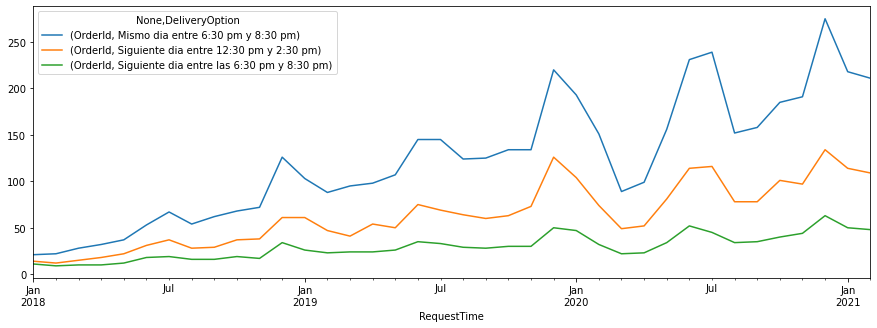

In [25]:
dfByRequestTime.resample('d').sum().resample('m').max().plot()

<ipython-input-26-ce40ee11cf9b>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  descomposicion = sm.tsa.seasonal_decompose(dfByDay['Option_1'],


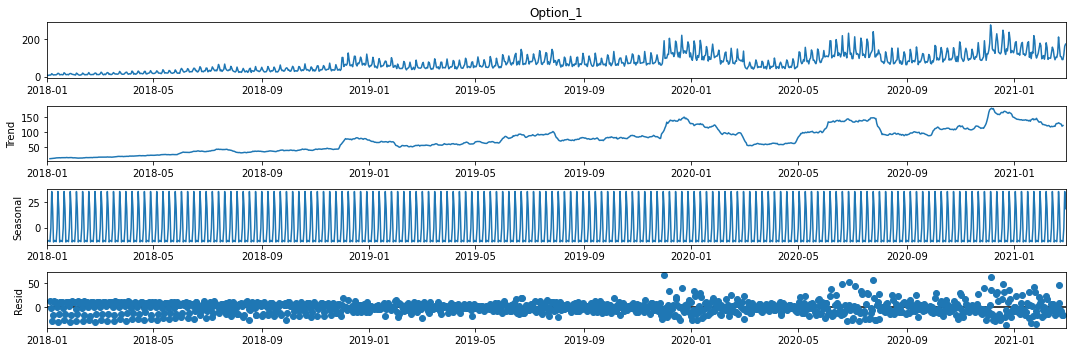

In [26]:
descomposicion = sm.tsa.seasonal_decompose(dfByDay['Option_1'],
                                                  model='additive', freq=7)  
fig = descomposicion.plot()


Creacion de la variable exogena

In [27]:
dfByDay['exogenous']=0
dfByDay.loc['2020-03-01':'2020-04-30','exogenous']=3
dfByDay.loc['2020-05-01':'2020-07-31','exogenous']=1
dfByDay.loc['2020-08-01':'2020-09-30','exogenous']=2
dfByDay.loc['2020-10-01':'2020-11-30','exogenous']=1
dfByDay.loc['2020-12-01':'2021-01-31','exogenous']=2
dfByDay.loc['2021-02-01':'2021-02-28','exogenous']=1

In [28]:
dfByDay.tail()

,Option_1,Option_2,Option_3,exogenous
RequestTime,,,,
2021-02-24,91,57,25,1
2021-02-25,91,50,20,1
2021-02-26,118,73,25,1
2021-02-27,162,105,48,1
2021-02-28,173,69,33,1


### Prueba serie estacionaria

In [29]:
from statsmodels.tsa.stattools import adfuller

In [30]:
for option in [dfByDay.Option_1,dfByDay.Option_2,dfByDay.Option_3]:
    adfTest = adfuller(option, autolag='AIC')
    print(f'The p-value for {option.name} series :{adfTest[1]}')

The p-value for Option_1 series :0.33285994468919294
The p-value for Option_2 series :0.34621860724959785
The p-value for Option_3 series :0.2564142071972091


P-value mayor 0.05 se considera que ninguna es estacionaria, se usará para los modelos el parametro d=1

In [31]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(dfByDay.Option_1, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=8872.548, Time=0.48 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=9766.527, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=9222.995, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=8888.268, Time=0.34 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.69 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=8870.575, Time=0.79 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=9106.599, Time=0.41 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=8860.330, Time=1.59 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=9032.985, Time=0.65 sec
 ARIMA(1,1,1)(2,1,2)[7]             : AIC=8862.218, Time=2.77 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=8876.543, Time=1.22 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=8874.660, Time=1.06 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=8996.312, Time=1.13 sec
 ARIMA(2,1,1)(2,1,1)[7]             : AIC=8862.240, Time=3.73 sec
 ARIMA(1,1,2)(2,1,1)[7]             : 

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMAResults

In [33]:
s_mod = SARIMAX(dfByDay['Option_1'], 
                order=(1,1,1), 
                seasonal_order=(2,1,1,7))
predictions = s_mod.fit().predict()

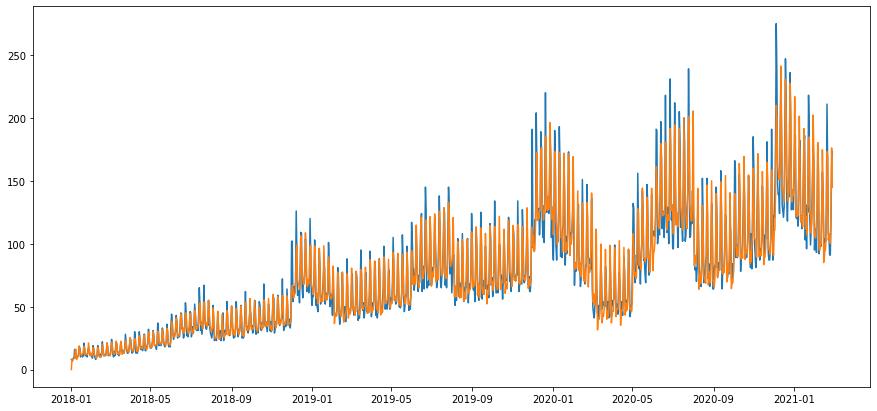

In [34]:
plt.rcParams["figure.figsize"] = (15, 7)
plt.plot(dfByDay.Option_1, label='original')
plt.plot(predictions, label='predictions')
plt.show()

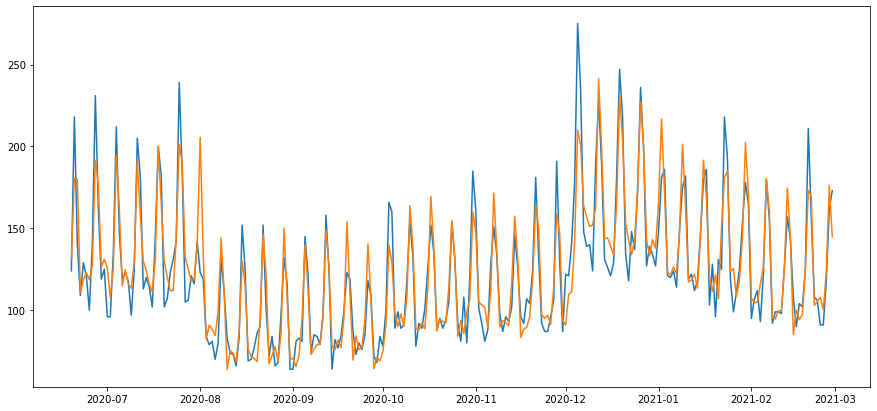

In [35]:
plt.rcParams["figure.figsize"] = (15, 7)
plt.plot(dfByDay.Option_1[900:], label='original')
plt.plot(predictions[900:], label='predictions')
plt.show()

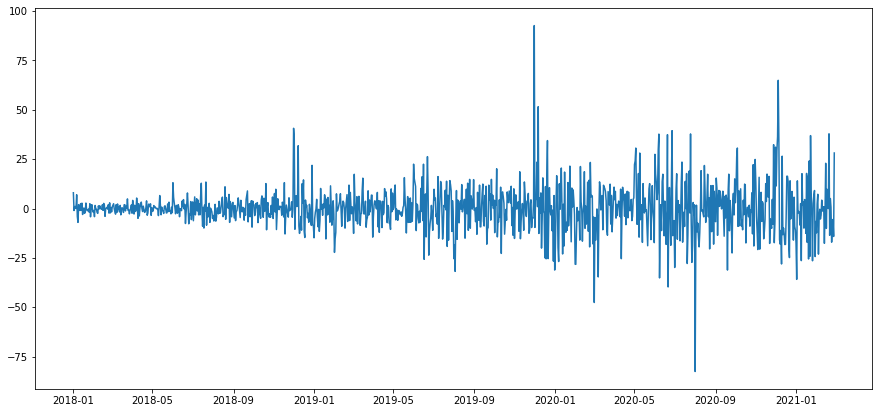

In [36]:
residuals = dfByDay.Option_1-predictions
plt.plot(residuals)
plt.show()

Se observa una buena distribución de los residuales

## Modelos de maximos mensuales

In [37]:
df_max_month=dfByRequestTime.resample('d').sum().resample('m').max()
df_max_month.columns=['Option_1', 'Option_2', 'Option_3']

In [38]:
df_max_month['exogenous']=0
df_max_month.loc['2020-03-01':'2020-04-30','exogenous']=3
df_max_month.loc['2020-05-01':'2020-07-31','exogenous']=1
df_max_month.loc['2020-08-01':'2020-09-30','exogenous']=2
df_max_month.loc['2020-10-01':'2020-11-30','exogenous']=1
df_max_month.loc['2020-12-01':'2021-01-31','exogenous']=2
df_max_month.loc['2021-02-01':'2021-02-28','exogenous']=1

In [39]:
for option in [df_max_month.Option_1,df_max_month.Option_2,df_max_month.Option_3]:
    adfTest = adfuller(option, autolag='AIC')
    print(f'The p-value for {option.name} series :{adfTest[1]}')

The p-value for Option_1 series :0.8398346233239347
The p-value for Option_2 series :0.8738587662159787
The p-value for Option_3 series :0.9471123479730248


De lo anterior se entiende que ninguna de las series de maximos es estacionaria, parametro d=1

In [40]:
train=df_max_month[:32]
test=df_max_month[32:]

## Modelo para la option 1

In [41]:
def modelArimax(train, test, train_exo, test_exo):
    stepwise_model = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True, 
                           information_criterion='aic')
    print(stepwise_model.aic())
    
    s_mod = SARIMAX(endog=train,
                exog=train_exo,
                order=stepwise_model.order, 
                seasonal_order=stepwise_model.seasonal_order)
    mod=s_mod.fit()
    predictions = mod.predict()
    
    
    result=mod.get_prediction(start=32, end=37, exog=test_exo)
    #test_pred=mod.predict(start=32, end=37, exog=test_exo)
    
    return mod, predictions, result
    
def plotArimax(original, predictions, result):   
    plt.rcParams["figure.figsize"] = (15, 7)
    plt.plot(original, label='original')
    plt.plot(predictions, label='predictions-train')
    plt.plot(result.predicted_mean, label='predictions-test')
    
    plt.fill_between(result.conf_int().iloc[:,0].index, 
                 result.conf_int().iloc[:,0], 
                 result.conf_int().iloc[:,1], 
                 color='k', alpha=.15)
    
    plt.show()
    
    residuals = original-predictions
    plt.plot(residuals)
    plt.show()
    
    adfTest=adfuller(residuals.dropna(), autolag='AIC')
    print(f'The p-value for residuals series :{adfTest[1]}')

In [42]:
mod_1, predictions_1, test_pred_1 =modelArimax(train.Option_1, test.Option_1, train.exogenous, test.exogenous)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=185.833, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=183.620, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=186.478, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=185.492, Time=0.06 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=185.175, Time=0.04 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=185.175, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=187.175, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=184.686, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=183.542, Time=0.02 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=185.492, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=187.492, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=181.359, Time=0.09 sec
 ARIMA(0,1,2)(1,1,0)[12]             : AIC=183.167, Time=0.19 sec
 ARIMA(0,1,2)(0,1,1)[12]             

/home/alan/anaconda3/envs/rappi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


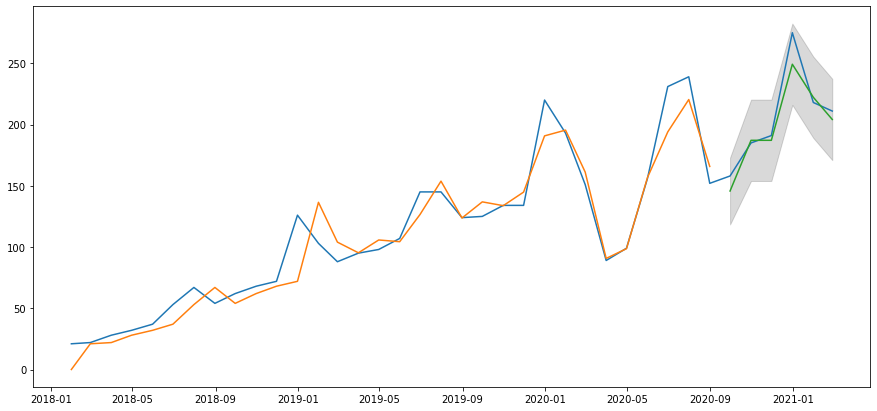

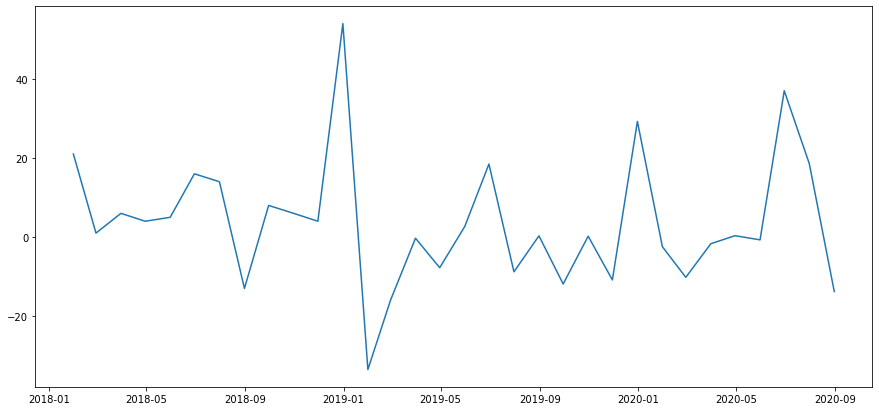

The p-value for residuals series :2.7527229122664564e-08


In [43]:
plotArimax(df_max_month.Option_1, predictions_1, test_pred_1)

Se considera ruido blanco de acuerdo al p-value

## Modelo para la opción 2

In [44]:
mod_2, predictions_2, test_pred_2 =modelArimax(train.Option_2, test.Option_2, train.exogenous, test.exogenous)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=163.063, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=166.999, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=164.490, Time=0.10 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=165.043, Time=0.05 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=165.043, Time=0.04 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=167.043, Time=0.04 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=164.999, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=164.942, Time=0.02 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=164.858, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 0.709 seconds
163.06263252548752


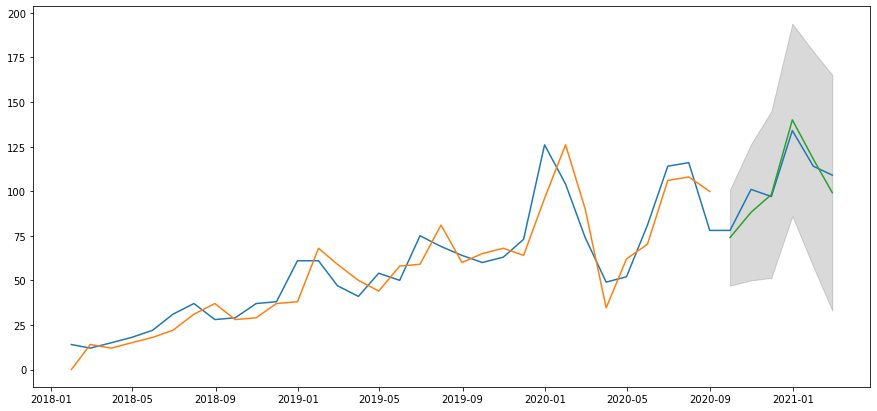

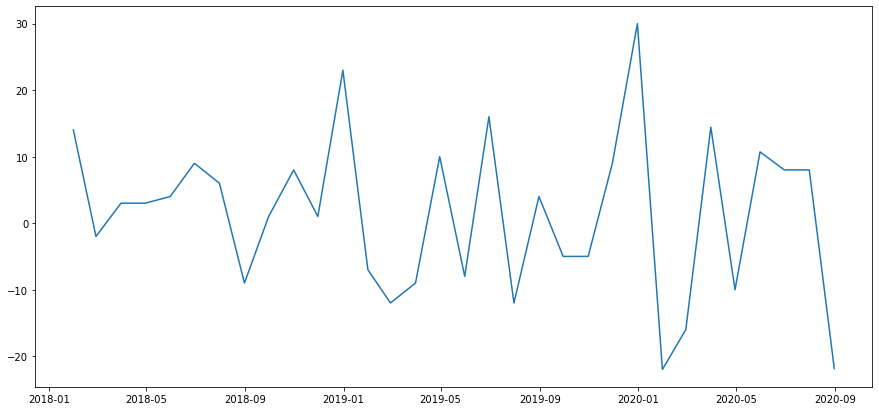

The p-value for residuals series :0.4977436124377207


In [45]:
plotArimax(df_max_month.Option_2, predictions_2, test_pred_2)

No se considera ruido blanco de acuerdo al p-value. El modelo no cumple con los requesitos de residuos

## Modelo para la Option 3

In [46]:
mod_3, predictions_3, test_pred_3 =modelArimax(train.Option_3, test.Option_3, train.exogenous, test.exogenous)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=119.174, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=120.274, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=122.160, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=117.915, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=117.098, Time=0.04 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=117.915, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=119.915, Time=0.08 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(0,1,2)(0,1,0)[12]             : AIC=inf, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=120.687, Time=0.02 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=inf, Time=0.09 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=118.993, Time=0.03 sec

Best model:  ARIMA(0,1,1)(0,1,0)[12]          
Total fit time: 0.891 seconds
117.09778813932452


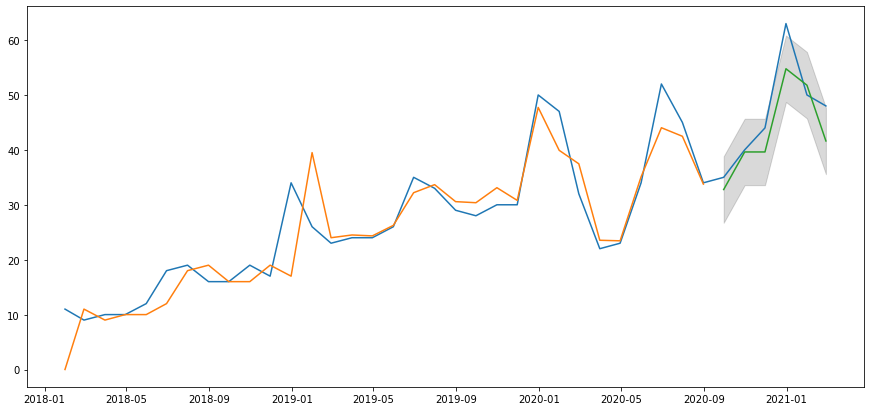

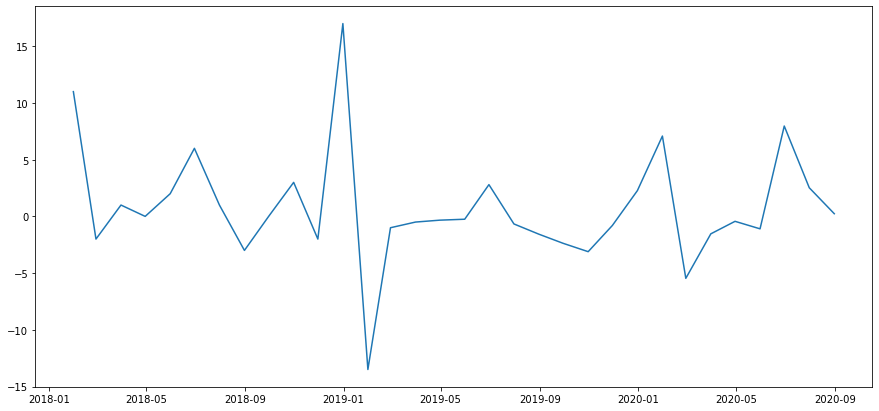

The p-value for residuals series :1.1828131149454788e-12


In [47]:
plotArimax(df_max_month.Option_3, predictions_3, test_pred_3)

Se considera ruido blanco de acuerdo al p-value

In [48]:
from statsmodels.tsa.statespace.varmax import VARMAX

In [49]:
train=train.astype('float64')
#train['Option_2']=train['Option_2'].astype('float64')

In [50]:
mod=VARMAX(train[['Option_1','Option_2', 'Option_3']], order=(1,1), trend='ct', exog=train.exogenous)
res = mod.fit(maxiter=1000, disp=False)
print(res.summary())

/home/alan/anaconda3/envs/rappi/lib/python3.8/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


                                    Statespace Model Results                                    
Dep. Variable:     ['Option_1', 'Option_2', 'Option_3']   No. Observations:                   32
Model:                                      VARMAX(1,1)   Log Likelihood                -284.369
                                            + intercept   AIC                            634.737
Date:                                  Mon, 14 Jun 2021   BIC                            683.107
Time:                                          12:22:35   HQIC                           650.771
Sample:                                      01-31-2018                                         
                                           - 08-31-2020                                         
Covariance Type:                                    opg                                         
Ljung-Box (L1) (Q):       0.02, 0.21, 1.49   Jarque-Bera (JB):    12.89, 0.81, 1.79
Prob(Q):                  0.89, 0.65, 0.22 

/home/alan/anaconda3/envs/rappi/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:1766: ValueWarning: Exogenous array provided, but additional data is not required. `exog` argument ignored.
  warnings.warn('Exogenous array provided, but additional data'


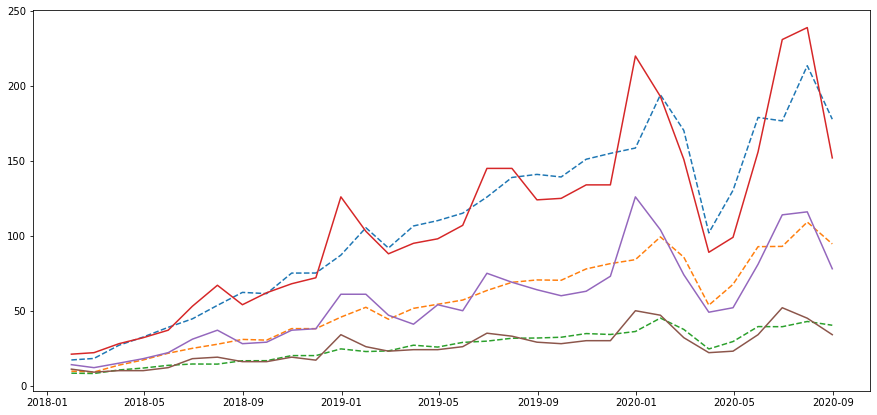

In [51]:
plt.plot(res.predict(),linestyle='dashed')
plt.plot(train[['Option_1','Option_2','Option_3']])
plt.show()

/home/alan/anaconda3/envs/rappi/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:1766: ValueWarning: Exogenous array provided, but additional data is not required. `exog` argument ignored.
  warnings.warn('Exogenous array provided, but additional data'


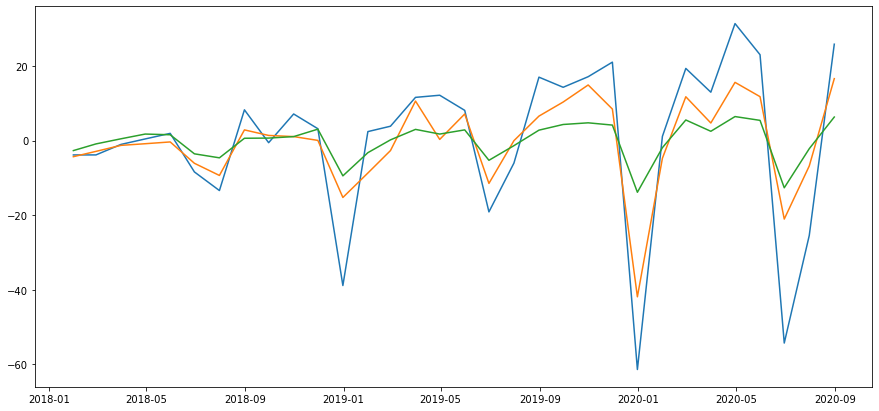

In [52]:
plt.plot(res.predict()-train[['Option_1','Option_2','Option_3']])

De los resultados del VARMAX no se observa un buen desempeño sobre la serie

In [53]:
residuals=res.predict()-train[['Option_1','Option_2','Option_3']]
residuals

/home/alan/anaconda3/envs/rappi/lib/python3.8/site-packages/statsmodels/tsa/statespace/mlemodel.py:1766: ValueWarning: Exogenous array provided, but additional data is not required. `exog` argument ignored.
  warnings.warn('Exogenous array provided, but additional data'


,Option_1,Option_2,Option_3
RequestTime,,,
2018-01-31,-3.866137,-4.331080,-2.697331
2018-02-28,-3.856320,-2.907602,-0.907079
2018-03-31,-1.039788,-1.296981,0.467485
2018-04-30,0.427159,-0.855867,1.736346
2018-05-31,1.922603,-0.375941,1.549248
2018-06-30,-8.418979,-6.099782,-3.563955
2018-07-31,-13.411604,-9.362855,-4.637937
2018-08-31,8.233524,2.853360,0.610562
2018-09-30,-0.576387,1.368530,0.657102


In [54]:
for option in residuals.columns:
    adfTest = adfuller(residuals[option], autolag='AIC')
    print(f'The p-value for {option} series :{adfTest[1]}')

The p-value for Option_1 series :0.6871698739761863
The p-value for Option_2 series :0.6406659176880042
The p-value for Option_3 series :0.7793412959276926


Los residuos no se comportan como ruido blanco. Lo cual refleja el pobre desempeño del modelo.

## Modelo diario

In [55]:
train=dfByDay[:1127]
test=dfByDay[1127:]

In [56]:
def modelArimax(train, test, train_exo, test_exo):
    stepwise_model = auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, 
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True, 
                           information_criterion='aic')
    print(stepwise_model.aic())
    
    s_mod = SARIMAX(endog=train,
                exog=train_exo,
                order=stepwise_model.order, 
                seasonal_order=stepwise_model.seasonal_order)
    mod=s_mod.fit()
    predictions = mod.predict()
    mod.summary()
    
    
    result=mod.get_prediction(start=1127, end=1154, exog=test_exo)
    #test_pred=mod.predict(start=32, end=37, exog=test_exo)
    
    return mod, predictions, result
    
def plotArimax(original, predictions, result):   
    plt.rcParams["figure.figsize"] = (15, 7)
    plt.plot(original, label='original')
    plt.plot(predictions, label='predictions-train')
    plt.plot(result.predicted_mean, label='predictions-test')
    
    plt.fill_between(result.conf_int().iloc[:,0].index, 
                 result.conf_int().iloc[:,0], 
                 result.conf_int().iloc[:,1], 
                 color='k', alpha=.15)
    
    plt.show()
    
    residuals = original-predictions
    plt.plot(residuals)
    plt.show()
    
    adfTest=adfuller(residuals.dropna(), autolag='AIC')
    print(f'The p-value for residuals series :{adfTest[1]}')

## Modelo Option 1

In [57]:
mod1, predictions1, result1 =modelArimax(train.Option_1, test.Option_1, train.exogenous, test.exogenous)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=8646.945, Time=0.52 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=9492.292, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=8980.802, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=8663.114, Time=0.32 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=inf, Time=0.72 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=8643.801, Time=0.80 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=8869.144, Time=0.39 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=8634.406, Time=1.57 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=8794.845, Time=0.60 sec
 ARIMA(1,1,1)(2,1,2)[7]             : AIC=8635.463, Time=3.82 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=8635.160, Time=2.66 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=8649.746, Time=1.04 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=8766.185, Time=1.27 sec
 ARIMA(2,1,1)(2,1,1)[7]             : AIC=8636.321, Time=2.08 sec
 ARIMA(1,1,2)(2,1,1)[7]             : 

In [58]:
mod1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          Option_1   No. Observations:                 1127
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 7)   Log Likelihood               -4293.351
Date:                           Mon, 14 Jun 2021   AIC                           8600.702
Time:                                   12:23:10   BIC                           8635.843
Sample:                               01-01-2018   HQIC                          8613.985
                                    - 01-31-2021                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exogenous    -12.4509      1.332     -9.345      0.000     -15.062      -9.839
ar.L1          0.2131      0.036      5.933      0.000       0.143       0.283
ma.L1         -0.7737      0.022    -35.812      0.000      -0.816      -0.731
ar.S.L7        0.1080      0.026      4.089      0.000       0.056       0.160
ar.S.L14       0.1168      0.026      4.501      0.000       0.066       0.168
ma.S.L7       -0.9154      0.012    -77.372      0.000      -0.939      -0.892
sigma2       124.7210      2.537     49.156      0.000     119.748     129.694
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              3353.19
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               7.12   Skew:                             0.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.35
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

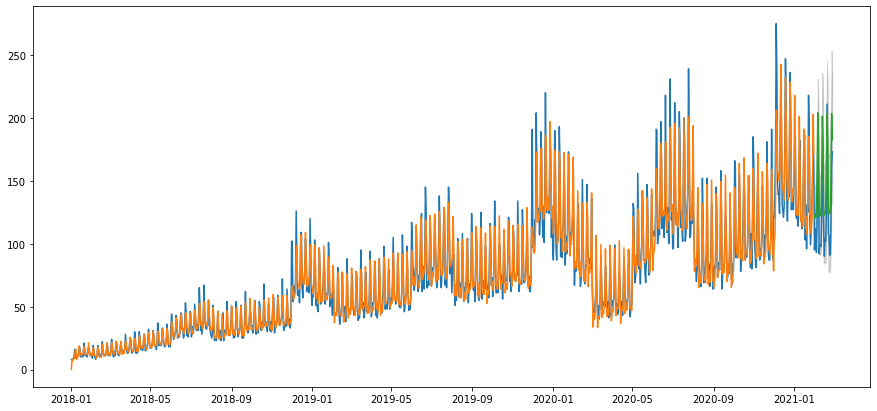

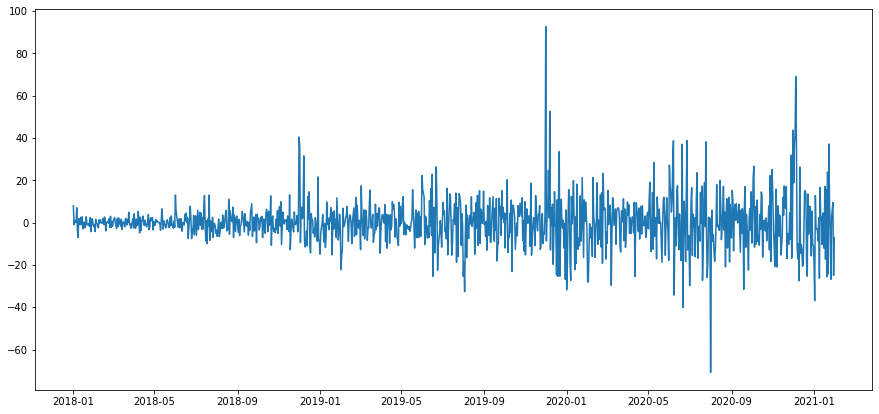

The p-value for residuals series :1.2375474536032495e-13


In [59]:
plotArimax(dfByDay.Option_1,predictions1,result1)

## Modelo option 2

In [60]:
mod2, predictions2, result2 =modelArimax(train.Option_2, test.Option_2, train.exogenous, test.exogenous)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=7180.068, Time=0.38 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=8079.246, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=7537.958, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=7187.767, Time=0.25 sec
 ARIMA(1,1,1)(0,1,0)[7]             : AIC=7669.501, Time=0.24 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=7172.746, Time=0.55 sec
 ARIMA(1,1,1)(1,1,0)[7]             : AIC=7400.654, Time=0.21 sec
 ARIMA(1,1,1)(2,1,1)[7]             : AIC=7165.762, Time=1.28 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=7317.517, Time=0.52 sec
 ARIMA(1,1,1)(2,1,2)[7]             : AIC=7163.506, Time=3.88 sec
 ARIMA(1,1,1)(1,1,2)[7]             : AIC=7161.865, Time=2.19 sec
 ARIMA(1,1,1)(0,1,2)[7]             : AIC=7174.886, Time=0.87 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=7168.660, Time=1.83 sec
 ARIMA(1,1,0)(1,1,2)[7]             : AIC=7303.187, Time=1.94 sec
 ARIMA(2,1,1)(1,1,2)[7]          

/home/alan/anaconda3/envs/rappi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alan/anaconda3/envs/rappi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alan/anaconda3/envs/rappi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


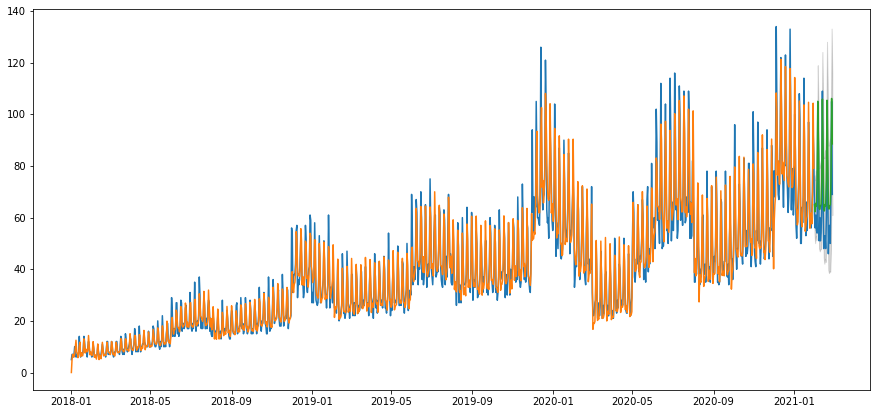

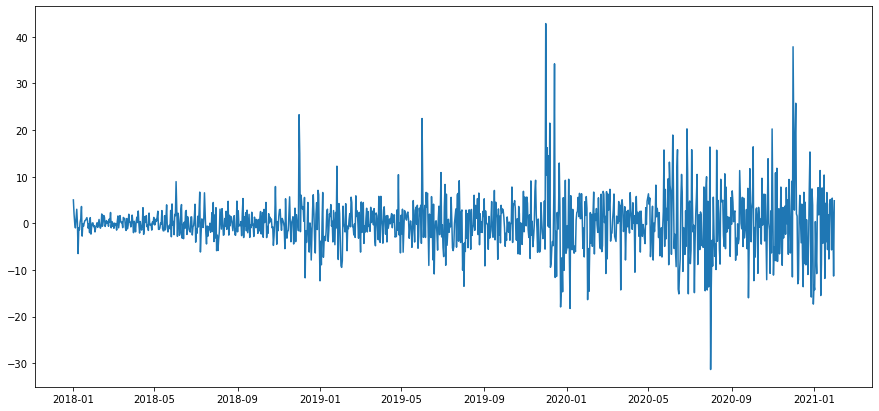

The p-value for residuals series :2.2200636992267807e-13


In [61]:
plotArimax(dfByDay.Option_2,predictions2,result2)

## Modelo Option 3

In [62]:
mod3, predictions3, result3 =modelArimax(train.Option_3, test.Option_3, train.exogenous, test.exogenous)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=5433.794, Time=0.35 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=6372.330, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=5770.669, Time=0.16 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=5433.447, Time=0.25 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=5980.833, Time=0.07 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=5435.319, Time=0.32 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=5435.342, Time=0.49 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=5659.816, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=5437.437, Time=0.55 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=5785.413, Time=0.12 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=5433.675, Time=0.34 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=5570.190, Time=0.20 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=5435.406, Time=0.80 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=5435.441, Time=0.85 sec

Best model:  ARIMA(0,1,1)(0,1,1)

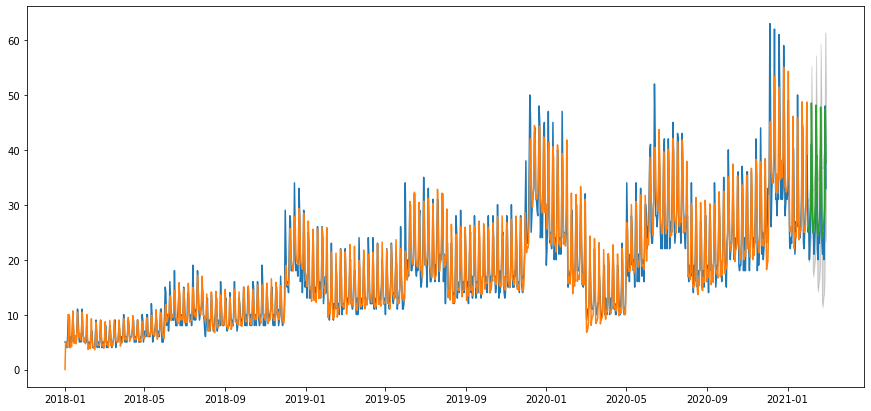

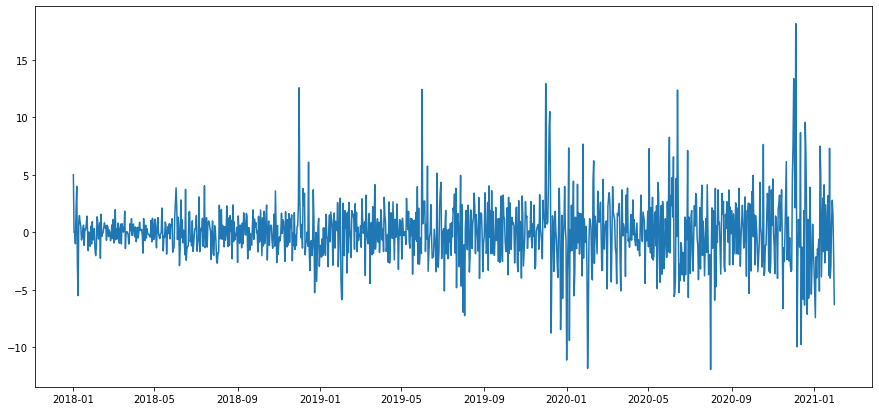

The p-value for residuals series :6.10385683351121e-16


In [63]:
plotArimax(dfByDay.Option_3,predictions3,result3)

## Predicciones para marzo

In [64]:
exo_mar=pd.DataFrame(np.zeros(31), index=np.arange('2021-03', '2021-04', dtype='datetime64[D]'), columns=['exogenous'])

In [65]:
def getFullmodel(model, endog, exog):
    s_mod = SARIMAX(endog=endog,
                exog=exog,
                order=model.specification['order'], 
                seasonal_order=model.specification['seasonal_order'])
    mod=s_mod.fit()
    predictions = mod.predict()
    return mod

In [66]:
def plotPrediction(result, actualData):
    plt.rcParams["figure.figsize"] = (15, 7)
    plt.plot(actualData, label='original')
    plt.plot(result.predicted_mean, label='predictions')
    
    plt.fill_between(result.conf_int().iloc[:,0].index, 
                 result.conf_int().iloc[:,0], 
                 result.conf_int().iloc[:,1], 
                 color='k', alpha=.15)
    
    plt.show()

In [67]:
modFull1=getFullmodel(mod1, dfByDay.Option_1, dfByDay.exogenous)
modFull2=getFullmodel(mod2, dfByDay.Option_2, dfByDay.exogenous)
modFull3=getFullmodel(mod3, dfByDay.Option_3, dfByDay.exogenous)

/home/alan/anaconda3/envs/rappi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/alan/anaconda3/envs/rappi/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/alan/anaconda3/envs/rappi/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [68]:
result_F1=modFull1.get_prediction(start=1155, end=1185, exog=exo_mar)
result_F2=modFull2.get_prediction(start=1155, end=1185, exog=exo_mar)
result_F3=modFull3.get_prediction(start=1155, end=1185, exog=exo_mar)

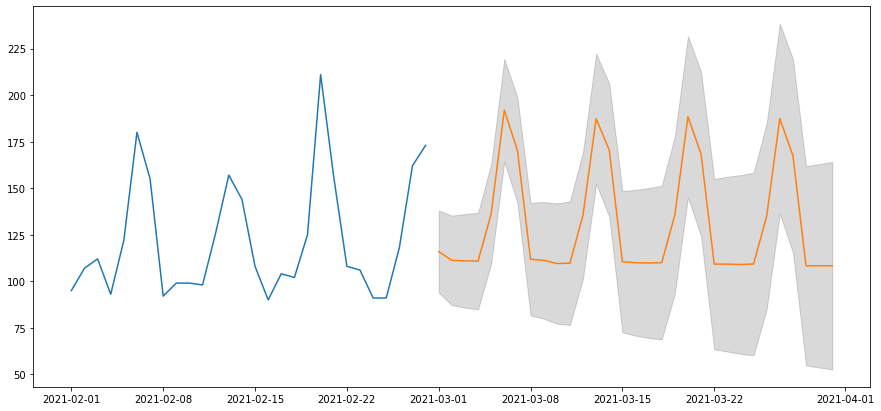

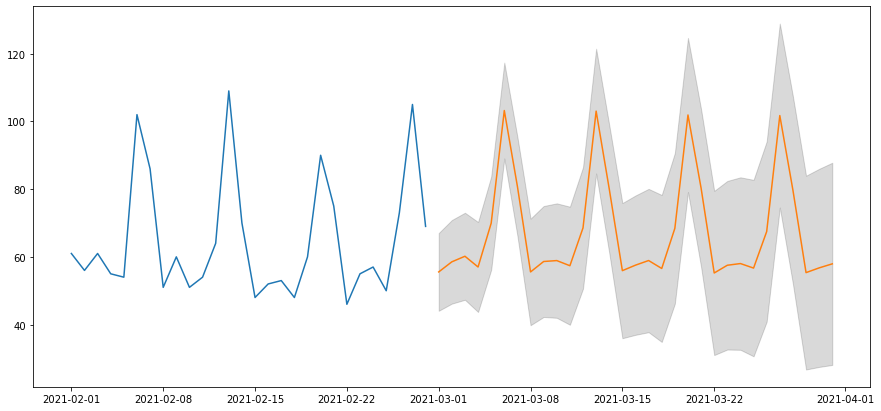

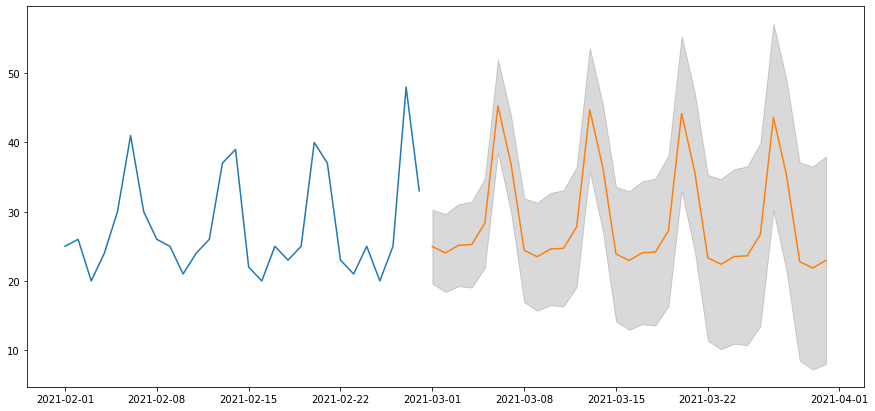

In [69]:
plotPrediction(result_F1, dfByDay.Option_1[1127:])
plotPrediction(result_F2, dfByDay.Option_2[1127:])
plotPrediction(result_F3, dfByDay.Option_3[1127:])

## Contratación de personal Marzo

In [70]:
afternoon=result_F1.predicted_mean
morning=result_F2.predicted_mean+result_F3.predicted_mean

In [71]:
np.ceil(morning.max()/(6*5))

5.0

In [72]:
np.ceil(afternoon.max()/(6*5))

7.0

De acuerdo a los modelos diarios se requieren **5** y **7** trabajadores para el turno de mañana y tarde respectivamente.